In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1

/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


In [2]:
import gc
import random
import joblib
import optuna
import datatable as dt
import lightgbm as lgb
import riiideducation
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

_ = np.seterr(divide='ignore', invalid='ignore')

# Preprocess

df表示をすると、メモリの残容量が減ってしまうので気を付ける必要がある。

In [3]:
%%time

data_types_dict = {
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'content_type_id':'int8', 
    'task_container_id': 'int16',
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'boolean'
}
target = 'answered_correctly'

# train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas()

train_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv', usecols = data_types_dict.keys(), dtype=data_types_dict, nrows=50*(10**6))

default_features = [col for col in train_df.columns if col != 'answered_correctly']

# print(default_features)
# print(train_df.shape)
# train_df.head()

CPU times: user 2min 2s, sys: 4.21 s, total: 2min 6s
Wall time: 2min 30s


test_dfには目的変数（answered_correctly）が含まれないため、特徴量のみで前処理すること。

※前処理でanswered_correctlyを使用すると、最後のtest_dfの処理ができなくなってしまう。

In [4]:
# lectures_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')

# print(lectures_df.shape)
# lectures_df.head()

In [5]:
# lectures_df['type_of'] = lectures_df['type_of'].replace('solving question', 'solving_question')

# lectures_df = pd.get_dummies(lectures_df, columns=['part', 'type_of'])

# part_lectures_columns = [column for column in lectures_df.columns if column.startswith('part')]
# types_of_lectures_columns = [column for column in lectures_df.columns if column.startswith('type_of_')]

# print(part_lectures_columns)
# print(types_of_lectures_columns)

# lectures_df.head()

In [6]:
# train_lectures = train_df[train_df.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')

# print(train_lectures.shape)
# train_lectures.head()

In [7]:
# user_lecture_stats_part = train_lectures.groupby('user_id',as_index = False)[part_lectures_columns + types_of_lectures_columns].sum()

# print(user_lecture_stats_part.shape)
# user_lecture_stats_part.head()

In [8]:
# lecturedata_types_dict = {   
    # 'user_id': 'int32', 
    # 'part_1': 'int8',
    # 'part_2': 'int8',
    # 'part_3': 'int8',
    # 'part_4': 'int8',
    # 'part_5': 'int8',
    # 'part_6': 'int8',
    # 'part_7': 'int8',
    # 'type_of_concept': 'int8',
    # 'type_of_intention': 'int8',
    # 'type_of_solving_question': 'int8',
    #'type_of_starter': 'int8'}

# user_lecture_stats_part = user_lecture_stats_part.astype(lecturedata_types_dict)

# for column in user_lecture_stats_part.columns:
    # if(column !='user_id'):
        # user_lecture_stats_part[column] = (user_lecture_stats_part[column] > 0).astype('int8')
        
# print(user_lecture_stats_part.shape)
# user_lecture_stats_part.head()

In [9]:
# del(train_lectures)
# gc.collect()

In [10]:
# user_lecture_agg = train_df.groupby('user_id')['content_type_id'].agg(['sum', 'count'])
# user_lecture_agg = user_lecture_agg.astype('int16')

# print(user_lecture_agg.shape)
# user_lecture_agg.head()

In [11]:
cum = train_df.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
cum['cumcount'] = cum['cumcount'] + 1

# print(cum.shape)
# cum.head()

In [12]:
train_df['user_interaction_count'] = cum['cumcount'] 
train_df['user_interaction_timestamp_mean'] = train_df['timestamp'] / cum['cumcount'] 
train_df['user_lecture_sum'] = cum['cumsum'] 
train_df['user_lecture_lv'] = cum['cumsum'] / cum['cumcount']

train_df['user_lecture_lv'] = train_df['user_lecture_lv'].astype('float16')
train_df['user_lecture_sum'] = train_df['user_lecture_sum'].astype('int16')
train_df['user_interaction_count'] = train_df['user_interaction_count'].astype('int16')
train_df['user_interaction_timestamp_mean'] = train_df['user_interaction_timestamp_mean'] / (1000*3600)
train_df['user_interaction_timestamp_mean'] = train_df['user_interaction_timestamp_mean'].astype('float32')

# print(train_df.shape)
# train_df.head()

In [13]:
del cum
gc.collect()

84

In [14]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)

train_df = train_df.astype(data_types_dict)
train_df = train_df[train_df[target] != -1].reset_index(drop=True)

# print(train_df.shape)
# train_df.head()

In [15]:
# content_explation_agg = train_df[["content_id","prior_question_had_explanation",target]].groupby(["content_id","prior_question_had_explanation"])[target].agg(['mean'])

# print(content_explation_agg.shape)
# content_explation_agg.head()

In [16]:
# content_explation_agg = content_explation_agg.unstack()
# content_explation_agg = content_explation_agg.reset_index()
# content_explation_agg.columns = ['content_id', 'content_explation_false_mean','content_explation_true_mean']

# content_explation_agg['content_id'] = content_explation_agg['content_id'].astype('int16')
# content_explation_agg['content_explation_false_mean'] = content_explation_agg['content_explation_false_mean'].astype('float16')
# content_explation_agg['content_explation_true_mean'] = content_explation_agg['content_explation_true_mean'].astype('float16')

# print(content_explation_agg.shape)
# content_explation_agg.head()

In [17]:
train_df["attempt_no"] = 1
train_df["attempt_no"] = train_df["attempt_no"].astype('int8')

attempt_no_agg = train_df.groupby(["user_id","content_id"])["attempt_no"].agg(['sum']).astype('int8')

# print(attempt_no_agg.shape)
# attempt_no_agg.head()

In [18]:
train_df["attempt_no"] = train_df[["user_id","content_id",'attempt_no']].groupby(["user_id","content_id"])["attempt_no"].cumsum()
attempt_no_agg = attempt_no_agg[attempt_no_agg['sum'] >1]

prior_question_elapsed_time_mean = train_df['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)

# print(train_df.shape)
# train_df.head()

In [19]:
max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id'])['timestamp'].agg(['max']).reset_index()
max_timestamp_u.columns = ['user_id', 'max_time_stamp']
max_timestamp_u['user_id'] = max_timestamp_u.user_id.astype('int32')

# print(max_timestamp_u.shape)
# max_timestamp_u.head()

In [20]:
train_df['lagtime'] = train_df.groupby('user_id')['timestamp'].shift()

# print(train_df.shape)
# train_df.head()

In [21]:
max_timestamp_u2 = train_df[['user_id','lagtime']].groupby(['user_id'])['lagtime'].agg(['max']).reset_index()
max_timestamp_u2.columns = ['user_id', 'max_time_stamp2']
max_timestamp_u2['user_id'] = max_timestamp_u2.user_id.astype('int32')

# print(max_timestamp_u2.shape)
# max_timestamp_u2.head()

In [22]:
train_df['lagtime'] = train_df['timestamp'] - train_df['lagtime']

lagtime_mean = train_df['lagtime'].mean()
train_df['lagtime'].fillna(lagtime_mean, inplace=True)

train_df['lagtime'] = train_df['lagtime']/(1000*3600)
train_df['lagtime'] = train_df['lagtime'].astype('float32')

# print(train_df.shape)
# train_df.head()

In [23]:
train_df['lagtime2'] = train_df.groupby('user_id')['timestamp'].shift(2)

# print(train_df.shape)
# train_df.head()

In [24]:
max_timestamp_u3 = train_df[['user_id','lagtime2']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u3.columns = ['user_id', 'max_time_stamp3']
max_timestamp_u3['user_id'] = max_timestamp_u3.user_id.astype('int32')

# print(max_timestamp_u3.shape)
# max_timestamp_u3.head()

In [25]:
train_df['lagtime2'] = train_df['timestamp']-train_df['lagtime2']

lagtime_mean2 = train_df['lagtime2'].mean()
train_df['lagtime2'].fillna(lagtime_mean2, inplace=True)

train_df['lagtime2'] = train_df['lagtime2']/(1000*3600)
train_df['lagtime2'] = train_df['lagtime2'].astype('float32')

# print(train_df.shape)
# train_df.head()

In [26]:
train_df['lagtime3'] = train_df.groupby('user_id')['timestamp'].shift(3)
train_df['lagtime3'] = train_df['timestamp'] - train_df['lagtime3']

lagtime_mean3 = train_df['lagtime3'].mean()
train_df['lagtime3'].fillna(lagtime_mean3, inplace=True)

train_df['lagtime3'] = train_df['lagtime3']/(1000*3600)
train_df['lagtime3'] = train_df['lagtime3'].astype('float32')

# print(train_df.shape)
# train_df.head()

In [27]:
train_df['timestamp'] = train_df['timestamp']/(1000*3600)
train_df['timestamp'] = train_df['timestamp'].astype('float16')

各user_idのグループごとに、最後の1行を抽出する。

In [28]:
user_prior_question_elapsed_time = train_df[['user_id','prior_question_elapsed_time']].groupby(['user_id']).tail(1)
user_prior_question_elapsed_time.columns = ['user_id', 'prior_question_elapsed_time']

# print(train_df['user_id'].nunique())
# print(user_prior_question_elapsed_time.shape)
# user_prior_question_elapsed_time.head()

In [29]:
train_df['delta_prior_question_elapsed_time'] = train_df.groupby('user_id')['prior_question_elapsed_time'].shift()
train_df['delta_prior_question_elapsed_time'] = train_df['prior_question_elapsed_time'] - train_df['delta_prior_question_elapsed_time']

delta_prior_question_elapsed_time_mean = train_df['delta_prior_question_elapsed_time'].mean()
train_df['delta_prior_question_elapsed_time'].fillna(delta_prior_question_elapsed_time_mean, inplace=True)

train_df['delta_prior_question_elapsed_time'] = train_df['delta_prior_question_elapsed_time'].astype('int32')

In [30]:
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].astype('int8')

explanation_agg = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['sum', 'count'])
explanation_agg = explanation_agg.astype('int16')

In [31]:
cum = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['cumsum', 'cumcount'])
cum['cumcount'] = cum['cumcount'] + 1

train_df['explanation_mean'] = cum['cumsum'] / cum['cumcount']
train_df['explanation_true_count'] = cum['cumsum'] 
train_df['explanation_false_count'] =  cum['cumcount'] - cum['cumsum']

del cum
gc.collect()

166

In [32]:
# content_elapsed_time_agg = train_df.groupby('content_id')['prior_question_elapsed_time'].agg(['mean'])
# content_had_explanation_agg = train_df.groupby('content_id')['prior_question_had_explanation'].agg(['mean'])

In [33]:
# questions_df = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv', usecols=[0, 1,3,4], dtype={'question_id': 'int16','bundle_id': 'int16', 'part': 'int8','tags': 'str'})

# print(questions_df.shape)
# questions_df.head()

In [34]:
# bundle_agg = questions_df.groupby('bundle_id')['question_id'].agg(['count'])

# print(bundle_agg.shape)
# bundle_agg.head()

In [35]:
# questions_df['content_sub_bundle'] = questions_df['bundle_id'].map(bundle_agg['count']).astype('int8')
# questions_df['tags'].fillna('188', inplace=True)

# print(questions_df.shape)
# questions_df.head()

In [36]:
'''
def gettags(tags,num):
    tags_splits = tags.split(" ")
    result = '' 
    
    for t in tags_splits:
        x = int(t)
        if(x < 32*(num+1) and x >= 32*num):
            result = result +' '+ t
    return result
    
'''

'\ndef gettags(tags,num):\n    tags_splits = tags.split(" ")\n    result = \'\' \n    \n    for t in tags_splits:\n        x = int(t)\n        if(x < 32*(num+1) and x >= 32*num):\n            result = result +\' \'+ t\n    return result\n    \n'

In [37]:
'''
for num in range(0,6):
    questions_df["tags" + str(num)] = questions_df["tags"].apply(lambda row: gettags(row,num))
    
    le = LabelEncoder()
    le.fit(np.unique(questions_df['tags' + str(num)].values))
    
    questions_df['tags' + str(num)] = questions_df[['tags' + str(num)]].apply(le.transform)
    
# print(questions_df.shape)
# questions_df.head()

'''

'\nfor num in range(0,6):\n    questions_df["tags" + str(num)] = questions_df["tags"].apply(lambda row: gettags(row,num))\n    \n    le = LabelEncoder()\n    le.fit(np.unique(questions_df[\'tags\' + str(num)].values))\n    \n    questions_df[\'tags\' + str(num)] = questions_df[[\'tags\' + str(num)]].apply(le.transform)\n    \n# print(questions_df.shape)\n# questions_df.head()\n\n'

In [38]:
'''
questions_df_dict = {   
    'tags0': 'int8',
    'tags1': 'int8',
    'tags2': 'int8',
    'tags3': 'int8',
    'tags4': 'int8',
    'tags5': 'int8',
}

questions_df = questions_df.astype(questions_df_dict)
questions_df.drop(columns=['tags'], inplace=True)

questions_df['part_bundle_id'] = questions_df['part']*100000 + questions_df['bundle_id']
questions_df['part_bundle_id'] = questions_df['part_bundle_id'].astype('int32')

questions_df.rename(columns={'question_id':'content_id'}, inplace=True)

# print(questions_df.shape)
# questions_df.head()

'''

"\nquestions_df_dict = {   \n    'tags0': 'int8',\n    'tags1': 'int8',\n    'tags2': 'int8',\n    'tags3': 'int8',\n    'tags4': 'int8',\n    'tags5': 'int8',\n}\n\nquestions_df = questions_df.astype(questions_df_dict)\nquestions_df.drop(columns=['tags'], inplace=True)\n\nquestions_df['part_bundle_id'] = questions_df['part']*100000 + questions_df['bundle_id']\nquestions_df['part_bundle_id'] = questions_df['part_bundle_id'].astype('int32')\n\nquestions_df.rename(columns={'question_id':'content_id'}, inplace=True)\n\n# print(questions_df.shape)\n# questions_df.head()\n\n"

In [39]:
# questions_df = pd.merge(questions_df, content_explation_agg, on='content_id', how='left',right_index=True)

# print(questions_df.shape)
# questions_df.head()

content_explain_aggには、answered_correctlyを含んだ処理をしているため<br>
これ以上進めたとしても、最後のtest_dfの処理ができない。

In [40]:
features_df = train_df.iloc[:int(9/10 * len(train_df))]
train_df = train_df.iloc[int(9/10 * len(train_df)):]

train_questions_only_df = features_df[features_df['answered_correctly']!=-1]
grouped_by_user_df = train_questions_only_df.groupby('user_id')
user_answers_df = grouped_by_user_df.agg({'answered_correctly': ['mean', 'count','std','median','skew']}).copy()
user_answers_df.columns = ['mean_user_accuracy', 
                           'questions_answered', 
                           'std_user_accuracy', 
                           'median_user_accuracy', 
                           'skew_user_accuracy']

grouped_by_content_df = train_questions_only_df.groupby('content_id')
content_answers_df = grouped_by_content_df.agg({'answered_correctly': ['mean', 'count','std','median','skew']}).copy()
content_answers_df.columns = ['mean_accuracy', 
                              'question_asked', 
                              'std_accuracy', 
                              'median_accuracy', 
                              'skew_accuracy']

del features_df
del grouped_by_user_df
del grouped_by_content_df


train_df = train_df.merge(user_answers_df, how='left', on='user_id')
train_df = train_df.merge(content_answers_df, how='left', on='content_id')

print(train_df.dtypes)
print(train_df.shape)
train_df.head()

timestamp                            float16
user_id                                int32
content_id                             int16
content_type_id                         int8
task_container_id                      int16
answered_correctly                      int8
prior_question_elapsed_time          float32
prior_question_had_explanation          int8
user_interaction_count                 int16
user_interaction_timestamp_mean      float32
user_lecture_sum                       int16
user_lecture_lv                      float16
attempt_no                              int8
lagtime                              float32
lagtime2                             float32
lagtime3                             float32
delta_prior_question_elapsed_time      int32
explanation_mean                     float64
explanation_true_count                 int64
explanation_false_count                int64
mean_user_accuracy                   float64
questions_answered                   float64
std_user_a

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_interaction_count,user_interaction_timestamp_mean,...,mean_user_accuracy,questions_answered,std_user_accuracy,median_user_accuracy,skew_user_accuracy,mean_accuracy,question_asked,std_accuracy,median_accuracy,skew_accuracy
0,39.50000,952250704,4434,0,32,0,12000.0,1,33,1.197112,...,0.483871,31.0,0.508001,0.0,0.067879,0.445108,10721,0.497001,0.0,0.220935
1,39.53125,952250704,408,0,33,0,22000.0,1,34,1.162406,...,0.483871,31.0,0.508001,0.0,0.067879,0.864004,3581,0.342832,1.0,-2.124704
2,39.53125,952250704,10687,0,34,0,16000.0,1,35,1.129377,...,0.483871,31.0,0.508001,0.0,0.067879,0.858635,55530,0.348401,1.0,-2.058823
3,39.53125,952250704,553,0,35,0,17000.0,1,36,1.098188,...,0.483871,31.0,0.508001,0.0,0.067879,0.658204,18394,0.474325,1.0,-0.667142
4,39.53125,952250704,402,0,38,1,15000.0,1,38,1.040685,...,0.483871,31.0,0.508001,0.0,0.067879,0.527622,12092,0.499257,1.0,-0.110669


# Modeling

In [41]:
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].astype(int)

features = ['timestamp',
            'prior_question_elapsed_time',
            'prior_question_had_explanation',
            'user_interaction_count',
            'user_interaction_timestamp_mean',
            'user_lecture_sum',
            'user_lecture_lv',
            'attempt_no',
            'lagtime',
            'lagtime2',
            'lagtime3',
            'delta_prior_question_elapsed_time',
            'explanation_mean',
            'explanation_true_count',
            'explanation_false_count',
            'mean_user_accuracy',
            'questions_answered',
            'std_user_accuracy',
            'median_user_accuracy',
            'skew_user_accuracy',
            'mean_accuracy',
            'question_asked',
            'std_accuracy',
            'median_accuracy',
            'skew_accuracy']

target = 'answered_correctly'

train_df = train_df.fillna(value=0.5)

print('features:', len(features))
print(train_df.isnull().sum())

features: 25
timestamp                            0
user_id                              0
content_id                           0
content_type_id                      0
task_container_id                    0
answered_correctly                   0
prior_question_elapsed_time          0
prior_question_had_explanation       0
user_interaction_count               0
user_interaction_timestamp_mean      0
user_lecture_sum                     0
user_lecture_lv                      0
attempt_no                           0
lagtime                              0
lagtime2                             0
lagtime3                             0
delta_prior_question_elapsed_time    0
explanation_mean                     0
explanation_true_count               0
explanation_false_count              0
mean_user_accuracy                   0
questions_answered                   0
std_user_accuracy                    0
median_user_accuracy                 0
skew_user_accuracy                   0
mean_accurac

In [42]:
# train_df, test_df = train_test_split(train_df, random_state=666, test_size=0.2)

test_df = train_df.groupby('user_id').tail(6)
train_df.drop(test_df.index, inplace=True)

In [43]:
'''
def create_model(trial):
    num_leaves = trial.suggest_int("num_leaves", 2, 31)
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    
    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        learning_rate=learning_rate,
        feature_fraction=feature_fraction,
        random_state=666
    )
    return model
    
def objective(trial):
    model = create_model(trial)
    model.fit(train_df[features], train_df[target])
    score = roc_auc_score(
        test_df[target].values, 
        model.predict_proba(test_df[features])[:,1]
    )
    return score
    
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=70)
params = study.best_params

print(params)

'''

'\ndef create_model(trial):\n    num_leaves = trial.suggest_int("num_leaves", 2, 31)\n    n_estimators = trial.suggest_int("n_estimators", 50, 300)\n    max_depth = trial.suggest_int(\'max_depth\', 3, 8)\n    min_child_samples = trial.suggest_int(\'min_child_samples\', 100, 1200)\n    learning_rate = trial.suggest_uniform(\'learning_rate\', 0.0001, 0.99)\n    min_data_in_leaf = trial.suggest_int(\'min_data_in_leaf\', 5, 90)\n    bagging_fraction = trial.suggest_uniform(\'bagging_fraction\', 0.0001, 1.0)\n    feature_fraction = trial.suggest_uniform(\'feature_fraction\', 0.0001, 1.0)\n    \n    model = lgb.LGBMClassifier(\n        num_leaves=num_leaves,\n        n_estimators=n_estimators, \n        max_depth=max_depth, \n        min_child_samples=min_child_samples, \n        min_data_in_leaf=min_data_in_leaf,\n        learning_rate=learning_rate,\n        feature_fraction=feature_fraction,\n        random_state=666\n    )\n    return model\n    \ndef objective(trial):\n    model = creat

In [44]:
# 10**6

'''
params = {'num_leaves': 19,
          'n_estimators': 253,
          'max_depth': 7,
          'min_child_samples': 917,
          'learning_rate': 0.08837048153511577,
          'min_data_in_leaf': 5,
          'bagging_fraction': 0.14076488112326396,
          'feature_fraction': 0.5982015442187711}
          
'''

"\nparams = {'num_leaves': 19,\n          'n_estimators': 253,\n          'max_depth': 7,\n          'min_child_samples': 917,\n          'learning_rate': 0.08837048153511577,\n          'min_data_in_leaf': 5,\n          'bagging_fraction': 0.14076488112326396,\n          'feature_fraction': 0.5982015442187711}\n          \n"

In [45]:
# 50*(10**6)

params = {'num_leaves': 20,
          'n_estimators': 248,
          'max_depth': 5,
          'min_child_samples': 746,
          'learning_rate': 0.7807865357938443,
          'min_data_in_leaf': 70,
          'bagging_fraction': 0.35616414641610444,
          'feature_fraction': 0.7300985638944109}

LGB score:  0.7242878516964628


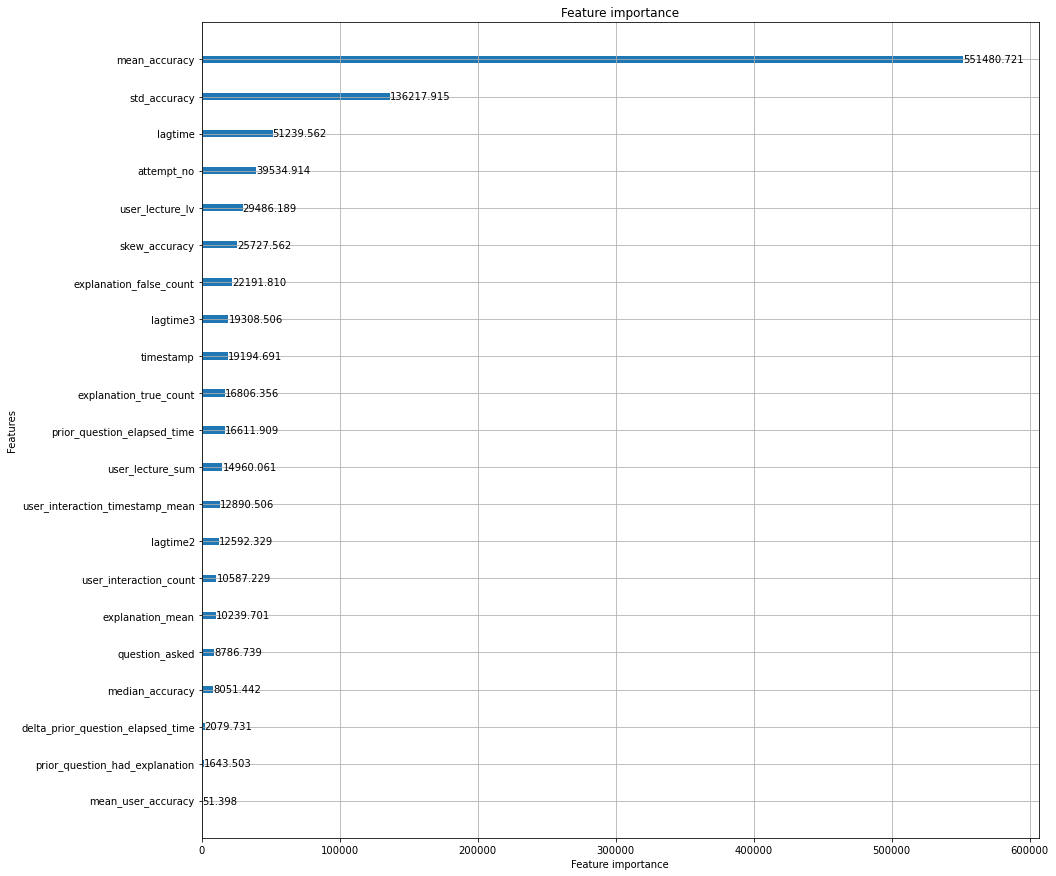

In [46]:
model = lgb.LGBMClassifier(**params)
model.fit(train_df[features], train_df[target])

print('LGB score: ', roc_auc_score(test_df[target].values, model.predict_proba(test_df[features])[:,1]))

fig,ax = plt.subplots(figsize=(15,15))
lgb.plot_importance(model, ax=ax,importance_type='gain',max_num_features=50)
plt.show()

In [47]:
# test_df = pd.read_csv("/kaggle/input/riiid-test-answer-prediction/example_test.csv")

# print(test_df.dtypes)
# print(test_df.shape)
# test_df.head()

In [48]:
env = riiideducation.make_env()
iter_test = env.iter_test()

In [49]:
data_types_dict = {'timestamp': 'int64',
                   'user_id': 'int32',
                   'content_id': 'int16',
                   'content_type_id': 'int8',
                   'task_container_id': 'int16',
                   'prior_question_elapsed_time': 'float32',
                   'prior_question_had_explanation': 'boolean'}

# submit(+ row_id)
default_features = ['row_id',
                    'timestamp',
                    'user_id',
                    'content_id',
                    'content_type_id',
                    'task_container_id',
                    'prior_question_elapsed_time',
                    'prior_question_had_explanation']

# print(default_features)
# print(data_types_dict)

In [50]:
for (test_df, sample_prediction_df) in iter_test:
    
    test_df = test_df[default_features]
    
    # test_lectures = test_df[test_df.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')
    # user_lecture_stats_part = test_lectures.groupby('user_id',as_index = False)[part_lectures_columns + types_of_lectures_columns].sum()
    
    # del(lectures_df)
    # del(test_lectures)
    # gc.collect()
    
    user_lecture_agg = test_df.groupby('user_id')['content_type_id'].agg(['sum', 'count'])
    user_lecture_agg = user_lecture_agg.astype('int16')
    
    cum = test_df.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
    cum['cumcount'] = cum['cumcount'] + 1
    
    test_df['user_interaction_count'] = cum['cumcount'] 
    test_df['user_interaction_timestamp_mean'] = test_df['timestamp'] / cum['cumcount'] 
    test_df['user_lecture_sum'] = cum['cumsum'] 
    test_df['user_lecture_lv'] = cum['cumsum'] / cum['cumcount']

    test_df['user_lecture_lv'] = test_df['user_lecture_lv'].astype('float16')
    test_df['user_lecture_sum'] = test_df['user_lecture_sum'].astype('int16')
    test_df['user_interaction_count'] = test_df['user_interaction_count'].astype('int16')
    test_df['user_interaction_timestamp_mean'] = test_df['user_interaction_timestamp_mean'] / (1000*3600)
    test_df['user_interaction_timestamp_mean'] = test_df['user_interaction_timestamp_mean'].astype('float32')
    
    del cum
    gc.collect()
    
    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df = test_df.astype(data_types_dict)
    # test_df = test_df[test_df[target] != -1].reset_index(drop=True)
    
    # content_explation_agg = test_df[["content_id","prior_question_had_explanation",target]].groupby(["content_id","prior_question_had_explanation"])[target].agg(['mean'])
    
    # content_explation_agg = content_explation_agg.unstack()
    # content_explation_agg = content_explation_agg.reset_index()
    # content_explation_agg.columns = ['content_id', 'content_explation_false_mean','content_explation_true_mean']

    # content_explation_agg['content_id'] = content_explation_agg['content_id'].astype('int16')
    # content_explation_agg['content_explation_false_mean'] = content_explation_agg['content_explation_false_mean'].astype('float16')
    # content_explation_agg['content_explation_true_mean'] = content_explation_agg['content_explation_true_mean'].astype('float16')
    
    test_df["attempt_no"] = 1
    test_df["attempt_no"] = test_df["attempt_no"].astype('int8')
    attempt_no_agg = test_df.groupby(["user_id","content_id"])["attempt_no"].agg(['sum']).astype('int8')
    
    test_df["attempt_no"] = test_df[["user_id","content_id",'attempt_no']].groupby(["user_id","content_id"])["attempt_no"].cumsum()
    attempt_no_agg = attempt_no_agg[attempt_no_agg['sum'] > 1]
    prior_question_elapsed_time_mean = test_df['prior_question_elapsed_time'].mean()
    test_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)
    
    max_timestamp_u = test_df[['user_id','timestamp']].groupby(['user_id'])['timestamp'].agg(['max']).reset_index()
    max_timestamp_u.columns = ['user_id', 'max_time_stamp']
    max_timestamp_u['user_id'] = max_timestamp_u['user_id'].astype('int32')
    
    test_df['lagtime'] = test_df.groupby('user_id')['timestamp'].shift()
    
    max_timestamp_u2 = test_df[['user_id','lagtime']].groupby(['user_id'])['lagtime'].agg(['max']).reset_index()
    max_timestamp_u2.columns = ['user_id', 'max_time_stamp2']
    max_timestamp_u2['user_id'] = max_timestamp_u2['user_id'].astype('int32')
    
    test_df['lagtime'] = test_df['timestamp'] - test_df['lagtime']

    lagtime_mean = test_df['lagtime'].mean()
    test_df['lagtime'].fillna(lagtime_mean, inplace=True)

    test_df['lagtime'] = test_df['lagtime'] / (1000*3600)
    test_df['lagtime'] = test_df['lagtime'].astype('float32')
    
    test_df['lagtime2'] = test_df.groupby('user_id')['timestamp'].shift(2)
    
    max_timestamp_u3 = test_df[['user_id','lagtime2']].groupby(['user_id']).agg(['max']).reset_index()
    max_timestamp_u3.columns = ['user_id', 'max_time_stamp3']
    max_timestamp_u3['user_id'] = max_timestamp_u3['user_id'].astype('int32')
    
    test_df['lagtime2'] = test_df['timestamp'] - test_df['lagtime2']

    lagtime_mean2 = test_df['lagtime2'].mean()
    test_df['lagtime2'].fillna(lagtime_mean2, inplace=True)

    test_df['lagtime2'] = test_df['lagtime2'] / (1000*3600)
    test_df['lagtime2'] = test_df['lagtime2'].astype('float32')
    
    test_df['lagtime3'] = test_df.groupby('user_id')['timestamp'].shift(3)
    test_df['lagtime3'] = test_df['timestamp'] - test_df['lagtime3']

    lagtime_mean3 = test_df['lagtime3'].mean()
    test_df['lagtime3'].fillna(lagtime_mean3, inplace=True)

    test_df['lagtime3'] = test_df['lagtime3'] / (1000*3600)
    test_df['lagtime3'] = test_df['lagtime3'].astype('float32')
    
    test_df['timestamp'] = test_df['timestamp'] / (1000*3600)
    test_df['timestamp'] = test_df['timestamp'].astype('float16')
    
    user_prior_question_elapsed_time = test_df[['user_id','prior_question_elapsed_time']].groupby(['user_id']).tail(1)
    user_prior_question_elapsed_time.columns = ['user_id', 'prior_question_elapsed_time']
    
    test_df['delta_prior_question_elapsed_time'] = test_df.groupby('user_id')['prior_question_elapsed_time'].shift()
    test_df['delta_prior_question_elapsed_time'] = test_df['prior_question_elapsed_time'] - test_df['delta_prior_question_elapsed_time']

    delta_prior_question_elapsed_time_mean = test_df['delta_prior_question_elapsed_time'].mean()
    test_df['delta_prior_question_elapsed_time'].fillna(delta_prior_question_elapsed_time_mean, inplace=True)

    test_df['delta_prior_question_elapsed_time'] = train_df['delta_prior_question_elapsed_time'].astype('int32')
    
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].astype('int8')

    explanation_agg = test_df.groupby('user_id')['prior_question_had_explanation'].agg(['sum', 'count'])
    explanation_agg = explanation_agg.astype('int16')
    
    cum = test_df.groupby('user_id')['prior_question_had_explanation'].agg(['cumsum', 'cumcount'])
    cum['cumcount'] = cum['cumcount'] + 1

    test_df['explanation_mean'] = cum['cumsum'] / cum['cumcount']
    test_df['explanation_true_count'] = cum['cumsum'] 
    test_df['explanation_false_count'] =  cum['cumcount'] - cum['cumsum']
    
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].astype(int)
    
    test_df = test_df.merge(user_answers_df, how='left', on='user_id')
    test_df = test_df.merge(content_answers_df, how='left', on='content_id')
    test_df.fillna(0.5, inplace=True)
    
    # target
    test_df[target] = 1
    test_df[target] = model.predict(test_df[features])
    
    # submit_data
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])